# 2D Example of Variational Diffusion Models (VDM)

Paper: https://arxiv.org/abs/2107.00630

This is a simple implementation of VDM for educational purposes.
 - Data: 2D 'swirl' data, in 8-bit (uint8) precision.
 - Score network: Fully connected MLP.

Note that is mainly for educational purposes: using VDM for 2D data is typically overkill, since it takes about 20 minutes to train this model, where for such 2D data something simpler like a mixture-of-Gaussians would give you similar results with much less compute.

This implementation was converted from Jax/Flax to PyTorch. The original version can be found [here](https://github.com/google-research/vdm)

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
from matplotlib.animation import FuncAnimation
from IPython import display
from tqdm.notebook import trange, tqdm
# from google.colab import files

# Define hyper-parameters

In [2]:
# Data hyper-parameters
N = 1024                 # nr of datapoints

# Model hyper-parameters
init_gamma_0 = -13.3    # initial gamma_0
init_gamma_1 = 5.       # initial gamma_1
hidden_units = 512
T_train = 0                   # nr of timesteps in model; T=0 means continuous-time
vocab_size = 256

# Optimization hyper-parameters
learning_rate = 3e-3
num_train_steps = 20000   # nr of training steps

torch.manual_seed(0)
np.random.seed(0)

DEVICE = 'cuda' #@param ["cpu", "cuda"]

# Create dataset

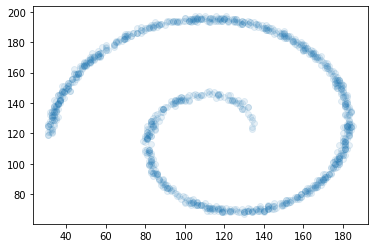

In [3]:
# Make 8-bit swirl dataset
theta = np.sqrt(np.random.rand(N))*3*np.pi # np.linspace(0,2*pi,100)
r_a = 2*theta + np.pi
x = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
# We use 8 bits, to make this a bit similar to image data, which has 8-bit
# color channels.
x = 4*(x + .25*np.random.randn(N,2) + 30)
x = x.astype('uint8')
plt.scatter(x[:,0],x[:,1], alpha=0.1)
plt.show()

# Get mean and standard deviation of 'x'
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)

# Get torch tensors
x_tens = torch.tensor(x, device=DEVICE)
x_mean_tens = torch.tensor(x_mean, device=DEVICE)
x_std_tens = torch.tensor(x_std, device=DEVICE)

# Define PyTorch model

In [4]:
# Define learnable model
class Model(nn.Module):

  def __init__(self):
    super().__init__()
    self.score_net = ScoreNetwork()
    self.noise_schedule = NoiseSchedule()

  def forward(self, x, t):
    gamma_t = self.noise_schedule(t)
    return self.score_net(x, gamma_t)
  
  def score(self, x, t):
    return self.score_net(x, t)
  
  def gamma(self, t):
    return self.noise_schedule(t)

  # define loss function
  def loss_fn(self, x):
    device = x.device

    gamma = lambda t: self.gamma(t)
    gamma_0, gamma_1 = gamma(0.), gamma(1.)
    # var_0, var_1 = torch.sigmoid(gamma_0), torch.sigmoid(gamma_1)
    var_1 = torch.sigmoid(gamma_1)
    n_batch = x.shape[0]

    # encode
    f = data_encode(x)

    # 1. RECONSTRUCTION LOSS
    # add noise and reconstruct
    eps_0 = torch.randn(size=f.shape, device=device)
    # z_0 = torch.sqrt(1. - var_0) * f + torch.sqrt(var_0) * eps_0
    # z_0_rescaled = z_0 / torch.sqrt(1. - var_0)
    z_0_rescaled = f + torch.exp(0.5 * gamma_0) * eps_0
    loss_recon = - data_logprob(x, z_0_rescaled, gamma_0)

    # 2. LATENT LOSS
    # KL z1 with N(0,1) prior
    mean1_sqr = (1. - var_1) * torch.square(f)
    loss_klz = 0.5 * torch.sum(mean1_sqr + var_1 - torch.log(var_1) - 1., dim=1)

    # 3. DIFFUSION LOSS
    # sample time steps
    t = torch.rand(size=(n_batch,), device=device)

    # discretize time steps if we're working with discrete time
    if T_train > 0:
      t = torch.ceil(t * T_train) / T_train

    # sample z_t
    gamma_t = gamma(t)
    var_t = torch.sigmoid(gamma_t)[:, None]
    eps = torch.randn(size=f.shape, device=device)
    z_t = (torch.sqrt(1. - var_t) * f + torch.sqrt(var_t) * eps).float()
    # compute predicted noise
    eps_hat = self.score(z_t, gamma_t)
    # compute MSE of predicted noise
    loss_diff_mse = torch.sum(torch.square(eps - eps_hat), dim=1)

    if T_train == 0:
      # loss for infinite depth T, i.e. continuous time
      t.requires_grad_(True)
      g_t_grad = torch.autograd.grad(gamma(t), t, torch.ones_like(t), create_graph=True)[0]
      loss_diff = .5 * g_t_grad * loss_diff_mse
    else:
      # loss for finite depth T, i.e. discrete time
      s = t - (1./T_train)
      gamma_s = gamma(s)
      loss_diff = .5 * T_train * torch.expm1(gamma_t - gamma_s) * loss_diff_mse

    # End of diffusion loss computation

    # Compute loss in terms of bits per dimension
    rescale_to_bpd = 1./(torch.numel(x[0]) * torch.log(torch.tensor(2.)))
    bpd_latent = torch.mean(loss_klz) * rescale_to_bpd
    bpd_recon = torch.mean(loss_recon) * rescale_to_bpd
    bpd_diff = torch.mean(loss_diff) * rescale_to_bpd 
    bpd = bpd_recon + bpd_latent + bpd_diff
    loss = bpd
    metrics = [bpd_latent.detach().cpu().numpy(), bpd_recon.detach().cpu().numpy(), bpd_diff.detach().cpu().numpy()]
    return loss, metrics

# A fully-connected MLP as the score network
class ScoreNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    self.dense1 = nn.Linear((2 + 1) * (2 * 8 + 1), hidden_units) # input size is (z=2 + gamma=1) * (ff=(8*2)+1)
    self.dense2 = nn.Linear(hidden_units, hidden_units)
    self.dense3 = nn.Linear(hidden_units, 2)
    self.ff = Base2FourierFeatures()

  def forward(self, z, gamma_t):

    # Normalize gamma_t
    lb = init_gamma_0
    ub = init_gamma_1
    gamma_t_norm = ((gamma_t - lb) / (ub - lb))*2-1  # ---> [-1,+1]

    # Concatenate normalized gamma_t as extra feature
    h = torch.cat([z, gamma_t_norm[:, None]], dim=1)

    # append Fourier features
    h_ff = self.ff(h)
    h = torch.cat([h, h_ff], dim=1)
    # Three dense layers
    h = F.silu(self.dense1(h))
    h = F.silu(self.dense2(h))
    h = self.dense3(h)

    return h

class Base2FourierFeatures(nn.Module):
  # Create Base 2 Fourier features
  def forward(self, inputs):
    freqs = torch.arange(8, dtype=inputs.dtype, device=inputs.device)
    w = 2.**freqs * 2 * np.pi
    w = w[None, :].repeat(1, inputs.shape[-1]).to(inputs.device)
    h = inputs.repeat_interleave(len(freqs), dim=-1)
    h *= w
    h = torch.cat([torch.sin(h), torch.cos(h)], dim=-1)
    return h

# Simple scalar noise schedule, i.e. gamma(t) in the paper:
# gamma(t) = abs(w) * t + b
class NoiseSchedule(nn.Module):

  def __init__(self):
    super().__init__()
    init_bias = init_gamma_0
    init_scale = init_gamma_1 - init_gamma_0
    self.w = nn.Parameter(torch.full((1,), init_scale, dtype=torch.float32))
    self.b = nn.Parameter(torch.full((1,), init_bias, dtype=torch.float32))

  def forward(self, t):
    return abs(self.w) * t + self.b

def data_encode(x):
  # This transforms x from discrete values (0, 1, ...)
  # to the domain (-1,1).
  return (x - x_mean_tens) / x_std_tens

def data_decode(z_0_rescaled, gamma_0):
  # Logits are exact if there are no dependencies between dimensions of x
  x_vals = torch.arange(0, vocab_size, device=gamma_0.device)[:, None]
  x_vals = x_vals.repeat_interleave(z_0_rescaled.shape[-1], dim=1)
  x_vals = data_encode(x_vals).transpose(1, 0)[None, :, :]
  inv_stdev = torch.exp(-0.5 * gamma_0[..., None])
  logits = -0.5 * torch.square((z_0_rescaled[..., None] - x_vals) * inv_stdev)

  logprobs = F.log_softmax(logits, dim=-1)
  return logprobs

def data_generate_x(z_0, gamma_0):
  var_0 = torch.sigmoid(gamma_0)
  z_0_rescaled = z_0 / torch.sqrt(1. - var_0)
  logits = data_decode(z_0_rescaled, gamma_0)
  samples = torch.distributions.Categorical(logits=logits).sample().to(gamma_0.device)
  return samples

def data_logprob(x, z_0_rescaled, gamma_0):
  x = x.type(torch.int64)            
  x_onehot = F.one_hot(x, vocab_size)
  logprobs = data_decode(z_0_rescaled, gamma_0)
  logprob = torch.sum(x_onehot * logprobs, dim=(1, 2))
  return logprob

# define training step
def train_step(optimizer, model, x):
  optimizer.zero_grad()
  loss, metrics = model.loss_fn(x)
  loss.backward()
  optimizer.step()
  return optimizer, model, loss, metrics


In [5]:
# Initialize model
model = Model().to(x_tens.device)

# Flax initializes Dense layers using lecun_normal with zero bias
@torch.no_grad()
def flax_dense_init_(m):
  if type(m) == nn.Linear:
    m.weight.normal_().clamp_(min=-2., max=2.).mul_((1. / m.in_features)**0.5 / .87962566103423978)
    m.bias.zero_()

model.apply(flax_dense_init_)

# initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Training loop

In [6]:
# training loop (should take ~20 mins on CPU, ~2 mins on GPU)
losses = []
for i in trange(num_train_steps):
  optimizer, model, loss, _metrics = train_step(optimizer, model, x_tens)
  losses.append(loss.detach().cpu().numpy())

  0%|          | 0/20000 [00:00<?, ?it/s]

# Plot results

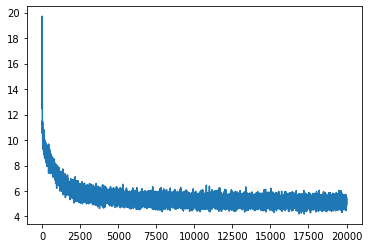

In [7]:
plt.plot(losses)

In [8]:
# Plot the learned endpoints of the noise schedule 
print('gamma_0', model.gamma(0.).detach().cpu().numpy())
print('gamma_1', model.gamma(1.).detach().cpu().numpy())

gamma_0 [-10.676606]
gamma_1 [6.951236]


In [9]:
# define sampling function
# t_end is integer between 0 and T_sample
@torch.no_grad()
def sample_fn(model, N_sample, T_sample):
  # sample z_0 from the diffusion model
  z = [torch.randn((N_sample, 2), device=next(model.parameters()).device)]
  x_pred = []

  for i in trange(T_sample):
    _z, _x_pred = sample_step(i, T_sample, z[-1])
    z.append(_z)
    x_pred.append(_x_pred)

  gamma_0 = model.gamma(0.)
  x_sample = data_generate_x(z[-1], gamma_0)

  return z, x_pred, x_sample

@torch.no_grad()
def sample_step(i, T_sample, z_t):

  eps = torch.randn(z_t.shape, device=z_t.device)

  t = (T_sample - i) / T_sample
  s = (T_sample - i - 1) / T_sample

  gamma_s = model.gamma(s).expand(z_t.shape[0])
  gamma_t = model.gamma(t).expand(z_t.shape[0])

  eps_hat = model.score(z_t.float(), gamma_t.float())
  a = torch.sigmoid(-gamma_s)[:,None]
  b = torch.sigmoid(-gamma_t)[:,None]
  c = - torch.expm1(gamma_s - gamma_t)[:,None]
  sigma_t = torch.sqrt(torch.sigmoid(gamma_t))[:,None]

  z_s = torch.sqrt(a / b) * (z_t - sigma_t * c * eps_hat) + \
      torch.sqrt((1. - a) * c) * eps

  alpha_t = torch.sqrt(1 - b)
  x_pred = (z_t - sigma_t * eps_hat)/alpha_t

  return z_s, x_pred


In [10]:
# Generate samples
z, x_pred, _ = sample_fn(model, N_sample=1024, T_sample=200)

  0%|          | 0/200 [00:00<?, ?it/s]

In [11]:
def plot_animation(data, dynamic_axis_lim=False, interval=50, html_video=True, ax_lim=2, col='blue'):
  fig, ax = plt.subplots()
  ax.set_aspect('equal', adjustable='box')
  scat = ax.scatter([],[], alpha=0.1, c=col)
  ax.set_xticks([-ax_lim,0,ax_lim])
  ax.set_yticks([-ax_lim,0,ax_lim])
  ax.set_xlim(-ax_lim,ax_lim)
  ax.set_ylim(-ax_lim,ax_lim)

  def animfunc(frame):
    scat.set_offsets(data[frame].cpu())
    if dynamic_axis_lim:
      all_lim = data[frame].cpu().abs().max().ceil()
      ax.set_xticks([-all_lim,0,all_lim])
      ax.set_yticks([-all_lim,0,all_lim])
      ax.set_xlim(-all_lim, all_lim)
      ax.set_ylim(-all_lim, all_lim)

  anim = FuncAnimation(fig, animfunc, frames=len(data), interval=interval)
  if html_video:
    video = anim.to_html5_video()
    htmlvid = display.HTML(video)
    display.display(htmlvid)
    plt.close()
  else:
    raise ValueError
  return anim

plot_animation(z)
plot_animation(x_pred, True)

In [12]:
@torch.no_grad()
def sample_q_t(t, x):
  if isinstance(x, np.ndarray): x = torch.tensor(x, device=DEVICE)
  f = data_encode(x)
  gamma_t = model.gamma(t)
  var_t = torch.sigmoid(gamma_t)[:, None]
  eps = torch.randn(size=x.shape, device=x.device)
  z_t = torch.sqrt(1. - var_t) * f + torch.sqrt(var_t) * eps
  return z_t

In [13]:
q_plot_data = torch.stack([sample_q_t(i/100, x) for i in reversed(range(100))])
plot_animation(q_plot_data, col='red')

In [14]:
@torch.no_grad()
def f_eps_hat(t, z_t):
  gamma_t = model.gamma(t)
  gamma_t = gamma_t.expand((z_t.shape[0]))
  eps_hat = model.score(z_t, gamma_t)
  return eps_hat

# Vector field
def vector_field(t, z, fname):
  eps_hat = f_eps_hat(t, z).detach().cpu().numpy()
  z = z.detach().cpu().numpy()
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.set_aspect('equal', adjustable='box')
  ax.set_xticks([-2,0,2])
  ax.set_yticks([-2,0,2])
  plt.quiver(z[:,0], z[:,1], -eps_hat[:,0], -eps_hat[:,1], width=.005)
  plt.xlim(-2,2)
  plt.ylim(-2,2)
##   if fname != None:
##     plt.savefig(fname)
##     files.download(fname)

In [15]:
# Create coordinate
_x = np.arange(-1.9, 1.9, 0.2)
_y = np.arange(-1.9, 1.9, 0.2)
_xs, _ys = np.meshgrid(_x, _y)
z_mesh = torch.tensor(
    np.concatenate([_xs.flatten()[:,None],_ys.flatten()[:,None]], axis=1),
    dtype=torch.float32, device=DEVICE)

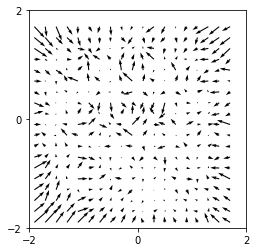

In [16]:
vector_field(0.0, z_mesh, 'vec_mesh_0.pdf')

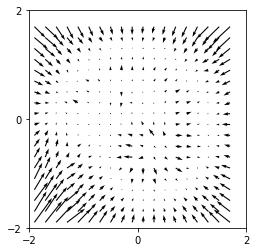

In [17]:
vector_field(.5, z_mesh, 'vec_mesh_.5.pdf')

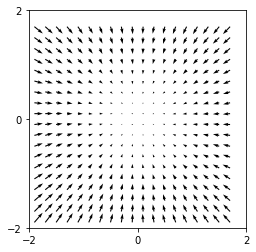

In [18]:
vector_field(1., z_mesh, 'vec_mesh_1.pdf')

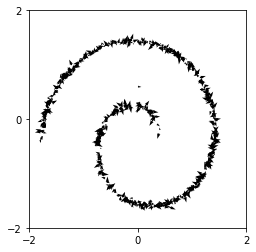

In [19]:
vector_field(.0, z[199], 'vec_z_0.pdf')

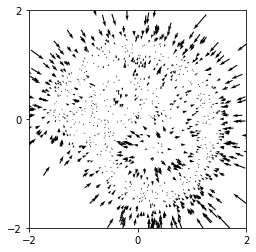

In [20]:
vector_field(.5, z[99], 'vec_z_.5.pdf')

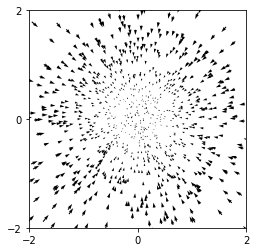

In [21]:
vector_field(1., z[0], 'vec_z_1.pdf')